In [577]:
from typing import Callable
import functools
import e3nn_jax as e3nn
import jax
import jax.numpy as jnp
import lovelyplots
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go
plt.style.use('ipynb')

In [578]:
def from_lm_index(lm_index):
    l = jnp.floor(jnp.sqrt(lm_index)).astype(jnp.int32)
    m = lm_index - l * (l + 1)
    return l, m

def to_lm_index(l, m):
    return l * (l + 1) + m


def sh_phi(l: int, m: int, phi: float) -> float:
    r"""Phi dependence of spherical harmonics.

    Args:
        l: l value
        phi: phi value

    Returns:
        Array of shape ``(2 * l + 1,)``
    """
    assert phi.ndim == 0
    phi = phi[..., None]  # [..., 1]
    ms = jnp.arange(1, l + 1)  # [1, 2, 3, ..., l]
    cos = jnp.cos(ms * phi)  # [..., m]

    ms = jnp.arange(l, 0, -1)  # [l, l-1, l-2, ..., 1]
    sin = jnp.sin(ms * phi)  # [..., m]

    return jnp.concatenate(
        [
            jnp.sqrt(2) * sin,
            jnp.ones_like(phi),
            jnp.sqrt(2) * cos,
        ],
        axis=-1,
    )[l + m]


def sh_theta(l: int, m: int, theta: float) -> float:
    r"""Beta dependence of spherical harmonics.

    Args:
        lmax: l value
        theta: theta value

    Returns:
        Array of shape ``(l, m)``
    """
    assert theta.ndim == 0
    cos_theta = jnp.cos(theta)
    legendres = e3nn.legendre.legendre(l, cos_theta, phase=1.0, is_normalized=True)  # [l, m, ...]
    sh_theta_comp = legendres[l, jnp.abs(m)]
    return sh_theta_comp

def spherical_harmonic(l: int, m: int) -> float:
    r"""Spherical harmonics.

    Args:
        l: l value
        m: m value
        theta: theta value
        phi: phi value

    Returns:
        Array of shape ``()``
    """
    def Y_lm(theta, phi):
        assert theta.shape == phi.shape
        return sh_theta(l, m, theta) * sh_phi(l, m, phi)
    return Y_lm

def create_signal_from_function(f: Callable[[float, float], float], thetas: jax.Array, phis: jax.Array,
                                wrap_theta: bool = True) -> jax.Array:
    r"""Create a signal from spherical harmonics.

    Args:
        l: l value
        m: m value
        thetas: theta values
        phis: phi values
        wrap_theta: wrap theta values between 0 and pi

    Returns:
        Array of shape ``(len(thetas), len(phis))``
    """
    if wrap_theta:
        thetas = jnp.where(thetas > jnp.pi, 2 * jnp.pi - thetas, thetas)
    thetas, phis = jnp.meshgrid(thetas, phis, indexing="ij")
    fn_vmap = jax.vmap(jax.vmap(f))
    return fn_vmap(thetas, phis)

In [579]:
theta = jnp.asarray(jnp.pi / 2)
sh_theta_comp_expected = jnp.asarray([
    jnp.sqrt(1 / (4 * jnp.pi)),
    jnp.sqrt(3 / (8 * jnp.pi)) * jnp.sin(theta),
    jnp.sqrt(3 / (4 * jnp.pi)) * jnp.cos(theta),
    jnp.sqrt(3 / (8 * jnp.pi)) * jnp.sin(theta),
])
sh_theta_comps = jnp.asarray([sh_theta(0, 0, theta), sh_theta(1, -1, theta), sh_theta(1, 0, theta), sh_theta(1, 1, theta)])
sh_theta_comp_expected, sh_theta_comps

(Array([ 2.8209478e-01,  3.4549415e-01, -2.1357494e-08,  3.4549415e-01],      dtype=float32),
 Array([ 2.8209478e-01,  3.4549415e-01, -2.1357494e-08,  3.4549415e-01],      dtype=float32))

Check that the SH match expected values
For l = 0:
- SH(0, 0) = 1/sqrt(4*pi)

In [580]:
def allclose(a, b):
    return jnp.allclose(a, b, atol=1e-5)

thetas = jnp.linspace(0, 2 * jnp.pi, 20)
phis = jnp.linspace(0, 2 * jnp.pi, 20)

expected_Y = {
    (0, 0): lambda theta, phi: jnp.sqrt(1/(4*jnp.pi)),
    (1, -1): lambda theta, phi: jnp.sin(theta) * jnp.sin(phi) * jnp.sqrt(3/(4*jnp.pi)),
    (1, 0): lambda theta, phi: jnp.cos(theta) * jnp.sqrt(3/(4*jnp.pi)),
    (1, 1): lambda theta, phi: jnp.sin(theta) * jnp.cos(phi) * jnp.sqrt(3/(4*jnp.pi)),
    (2, -2): lambda theta, phi: jnp.sin(theta)**2 * jnp.sin(2*phi) * jnp.sqrt(15/(16*jnp.pi)),
    (2, -1): lambda theta, phi: jnp.sin(theta) * jnp.cos(theta) * jnp.sin(phi) * jnp.sqrt(15/(4*jnp.pi)),
    (2, 0): lambda theta, phi: (3*jnp.cos(theta)**2 - 1) * jnp.sqrt(5/(16*jnp.pi)),
    (2, 1): lambda theta, phi: jnp.sin(theta) * jnp.cos(theta) * jnp.cos(phi) * jnp.sqrt(15/(4*jnp.pi)),
    (2, 2): lambda theta, phi: jnp.sin(theta)**2 * jnp.cos(2*phi) * jnp.sqrt(15/(16*jnp.pi)),
}

failed = []
for l in range(3):
    for m in range(-l, l+1):
        expected = create_signal_from_function(expected_Y[(l, m)], thetas, phis)
        actual = create_signal_from_function(spherical_harmonic(l, m), thetas, phis)
        if not allclose(actual, expected):
            print(f"l={l}, m={m} failed, diff={jnp.abs(actual - expected).max()}")
            max_diff = jnp.abs(actual - expected).max()
            failed_theta, failed_phi = jnp.unravel_index(jnp.argmax(jnp.abs(actual - expected)), actual.shape)
            print(f"Failed at theta={thetas[failed_theta]}, phi={phis[failed_phi]}")
            failed.append((l, m))
if not failed:
    print("All tests passed")

All tests passed


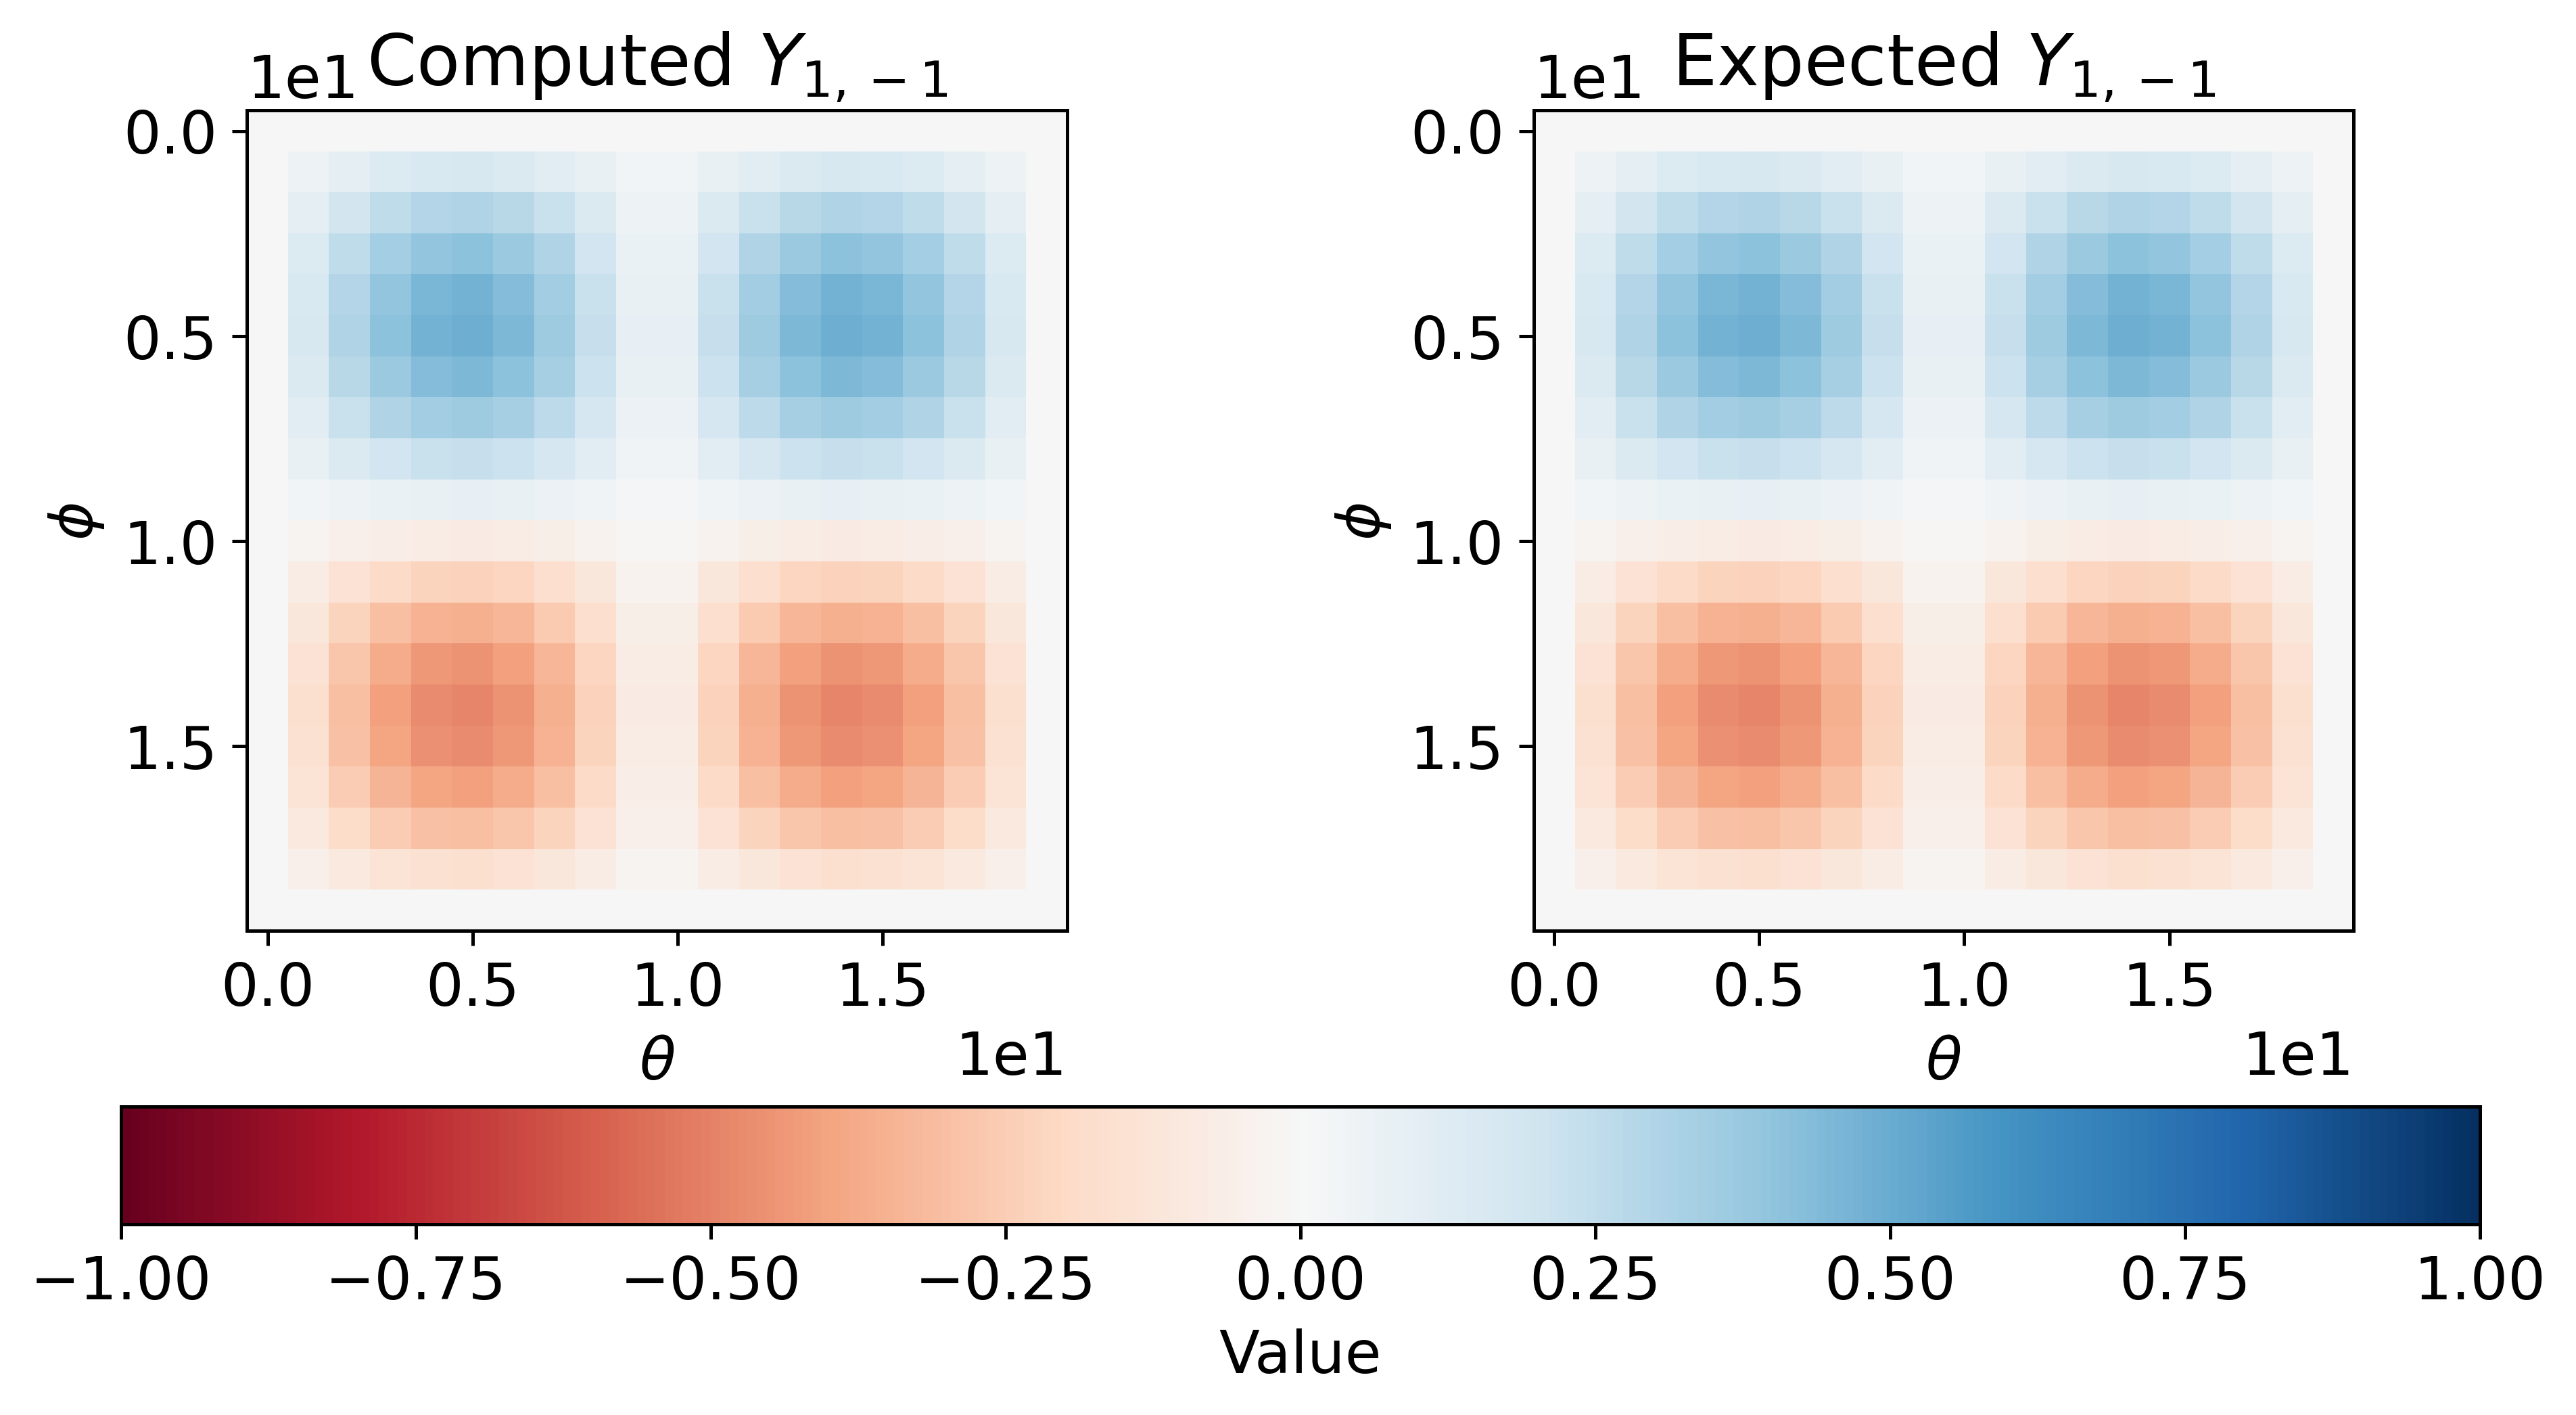

In [581]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

axs[0].imshow(create_signal_from_function(spherical_harmonic(1, -1), thetas, phis).T, cmap='RdBu', vmin=-1, vmax=1)
axs[0].set_xlabel(r"$\theta$")
axs[0].set_ylabel(r"$\phi$")
axs[0].set_title(r"Computed $Y_{1,-1}$")

axs[1].imshow(create_signal_from_function(expected_Y[(1, -1)], thetas, phis).T, cmap='RdBu', vmin=-1, vmax=1)
axs[1].set_xlabel(r"$\theta$")
axs[1].set_ylabel(r"$\phi$")
axs[1].set_title(r"Expected $Y_{1,-1}$")
fig.colorbar(mappable=axs[0].images[0], ax=axs, orientation='horizontal', label='Value')
plt.show()

In [582]:
class RectangularSignal:
    """Create a signal defined on a rectangular region from a function of theta and phi."""

    def __init__(self, f: Callable[[float, float], float], res_theta: int, res_phi: int, wrap_theta: bool = True):
        self.f = f
        self.res_theta = res_theta
        self.res_phi = res_phi
        self.wrap_theta = wrap_theta
    
    def thetas(self):
        """Returns the theta values of the grid."""
        return jnp.linspace(0, 2 * jnp.pi, self.res_theta)
    
    def phis(self):
        """Returns the phi values of the grid."""
        return jnp.linspace(0, 2 * jnp.pi, self.res_phi)
    
    def grid_values(self) -> jax.Array:
        """Computes the values of the signal on the grid."""
        return create_signal_from_function(self.f, self.thetas(), self.phis(), wrap_theta=self.wrap_theta)
    
    def integrate(self) -> jax.Array:
        """Computes the integral of the signal over the sphere."""
        grid_values = self.grid_values(self.thetas(), self.phis())

        # Integrate over theta axis first, with the trapezoidal rule.
        dtheta = 2 * jnp.pi / self.res_theta
        thetas = self.thetas()
        theta_weights = jnp.concatenate([jnp.array([0.5]), jnp.ones(len(thetas) - 2), jnp.array([0.5])])
        integral = jnp.sum(grid_values * theta_weights[None, :], axis=0) * dtheta
        assert integral.shape == (self.res_phi,)

        # Integrate over phi axis next, with the trapezoidal rule.
        dphi = 2 * jnp.pi / self.res_phi
        phis = self.phis()
        phi_weights = jnp.concatenate([jnp.array([0.5]), jnp.ones(len(phis) - 2), jnp.array([0.5])])
        integral = jnp.sum(integral * phi_weights[None, :], axis=0) * dphi
        return integral
    
    def __mul__(self, other):
        """Pointwise multiplication of two signals."""
        assert isinstance(other, RectangularSignal)
        assert self.res_theta == other.res_theta
        assert self.res_phi == other.res_phi
        assert self.wrap_theta == other.wrap_theta
        return RectangularSignal(lambda theta, phi: self.f(theta, phi) * other.f(theta, phi), self.res_theta, self.res_phi, wrap_theta=self.wrap_theta)

$Y_{lm}(\theta, \phi) = \sum_{u,v} ({y^{lm}_{uv}})^* \exp{i (u \theta + v \phi)}$


In [583]:
def fourier_function(u: int, v: int) -> Callable[[float, float], float]:
    """Fourier function on the sphere."""
    def fourier(theta, phi):
        return jnp.exp(1j * (u * theta + v * phi)) / jnp.sqrt(4 * jnp.pi)
    return fourier


def compute_y(l: int, m: int, u: int, v: int, **grid_kwargs):
    """Computes y^{l,m}_{u, v}."""
    Y_signal = RectangularSignal(spherical_harmonic(l, m), **grid_kwargs)
    F_signal = RectangularSignal(fourier_function(u, v), **grid_kwargs)
    product = Y_signal * F_signal
    return product.integrate()


@functools.partial(jax.jit, static_argnames=('lmax', 'res_theta', 'res_phi', 'wrap_theta'))
def compute_y_grid(lmax: int, **grid_kwargs):
    lm_indices = jnp.arange((lmax + 1) ** 2)
    us = jnp.arange(-lmax, lmax + 1)
    vs = jnp.arange(-lmax, lmax + 1)
    mesh = jnp.meshgrid(lm_indices, us, vs, indexing='ij')
    compute_y_fn = functools.partial(compute_y, lmax=lmax, **grid_kwargs)
    y_grid = jax.vmap(jax.vmap(jax.vmap(compute_y_fn)))(*mesh)
    assert y_grid.shape == ((lmax + 1) ** 2, 2 * lmax + 1, 2 * lmax + 1)
    return y_grid

In [584]:
def to_spherical_coords(xyz):
    x, y, z = xyz
    r = jnp.sqrt(x ** 2 + y ** 2 + z ** 2)
    theta = jnp.arccos(y / r)
    phi = jnp.arctan2(z, x)
    return r, theta, phi


def create_Y_signal(l: int, m: int, lmax: int, **s2grid_kwargs) -> e3nn.SphericalSignal:
    coeffs = jnp.zeros((lmax + 1) ** 2).at[to_lm_index(l, m)].set(1)
    coeffs = e3nn.IrrepsArray(e3nn.s2_irreps(lmax), coeffs)
    return e3nn.to_s2grid(coeffs, **s2grid_kwargs)

def create_Fourier_signal(u: int, v: int, **s2grid_kwargs) -> e3nn.SphericalSignal:
    signal = e3nn.SphericalSignal.zeros(**s2grid_kwargs)
    xyz_coords = signal.grid_vectors
    _, theta, phi = jax.vmap(jax.vmap(to_spherical_coords))(xyz_coords)
    values = jnp.exp(1j * (u * theta + v * phi)) / jnp.sqrt(4 * jnp.pi)
    signal = signal.replace_values(
        values
    )
    return signal

def compute_y(lm_index: int, u: int, v: int, lmax: int, **s2grid_kwargs):
    l, m = from_lm_index(lm_index)
    Y = create_Y_signal(l, m, lmax, **s2grid_kwargs)
    F = create_Fourier_signal(u, v, **s2grid_kwargs)
    product =  (F * Y).integrate().array[0]
    return product

@functools.partial(jax.jit, static_argnames=('lmax', 'res_beta', 'res_alpha', 'quadrature', 'p_val', 'p_arg'))
def compute_y_grid(lmax: int, **s2grid_kwargs):
    lm_indices = jnp.arange((lmax + 1) ** 2)
    us = jnp.arange(-lmax, lmax + 1)
    vs = jnp.arange(-lmax, lmax + 1)
    mesh = jnp.meshgrid(lm_indices, us, vs, indexing='ij')
    compute_y_fn = functools.partial(compute_y, lmax=lmax, **s2grid_kwargs)
    y_grid = jax.vmap(jax.vmap(jax.vmap(compute_y_fn)))(*mesh)
    assert y_grid.shape == ((lmax + 1) ** 2, 2 * lmax + 1, 2 * lmax + 1)
    return y_grid

In [585]:
s2grid_kwargs = dict(
    res_beta=180,
    res_alpha=179,
    quadrature="gausslegendre",
    p_val=1,
    p_arg=-1,
)

lmax = 6
y_grid = compute_y_grid(lmax, **s2grid_kwargs)
y_grid.shape

(49, 13, 13)

In [586]:
l, m = 4, 2
assert jnp.abs(m) <= l

y_lm = y_grid[to_lm_index(l, m)]

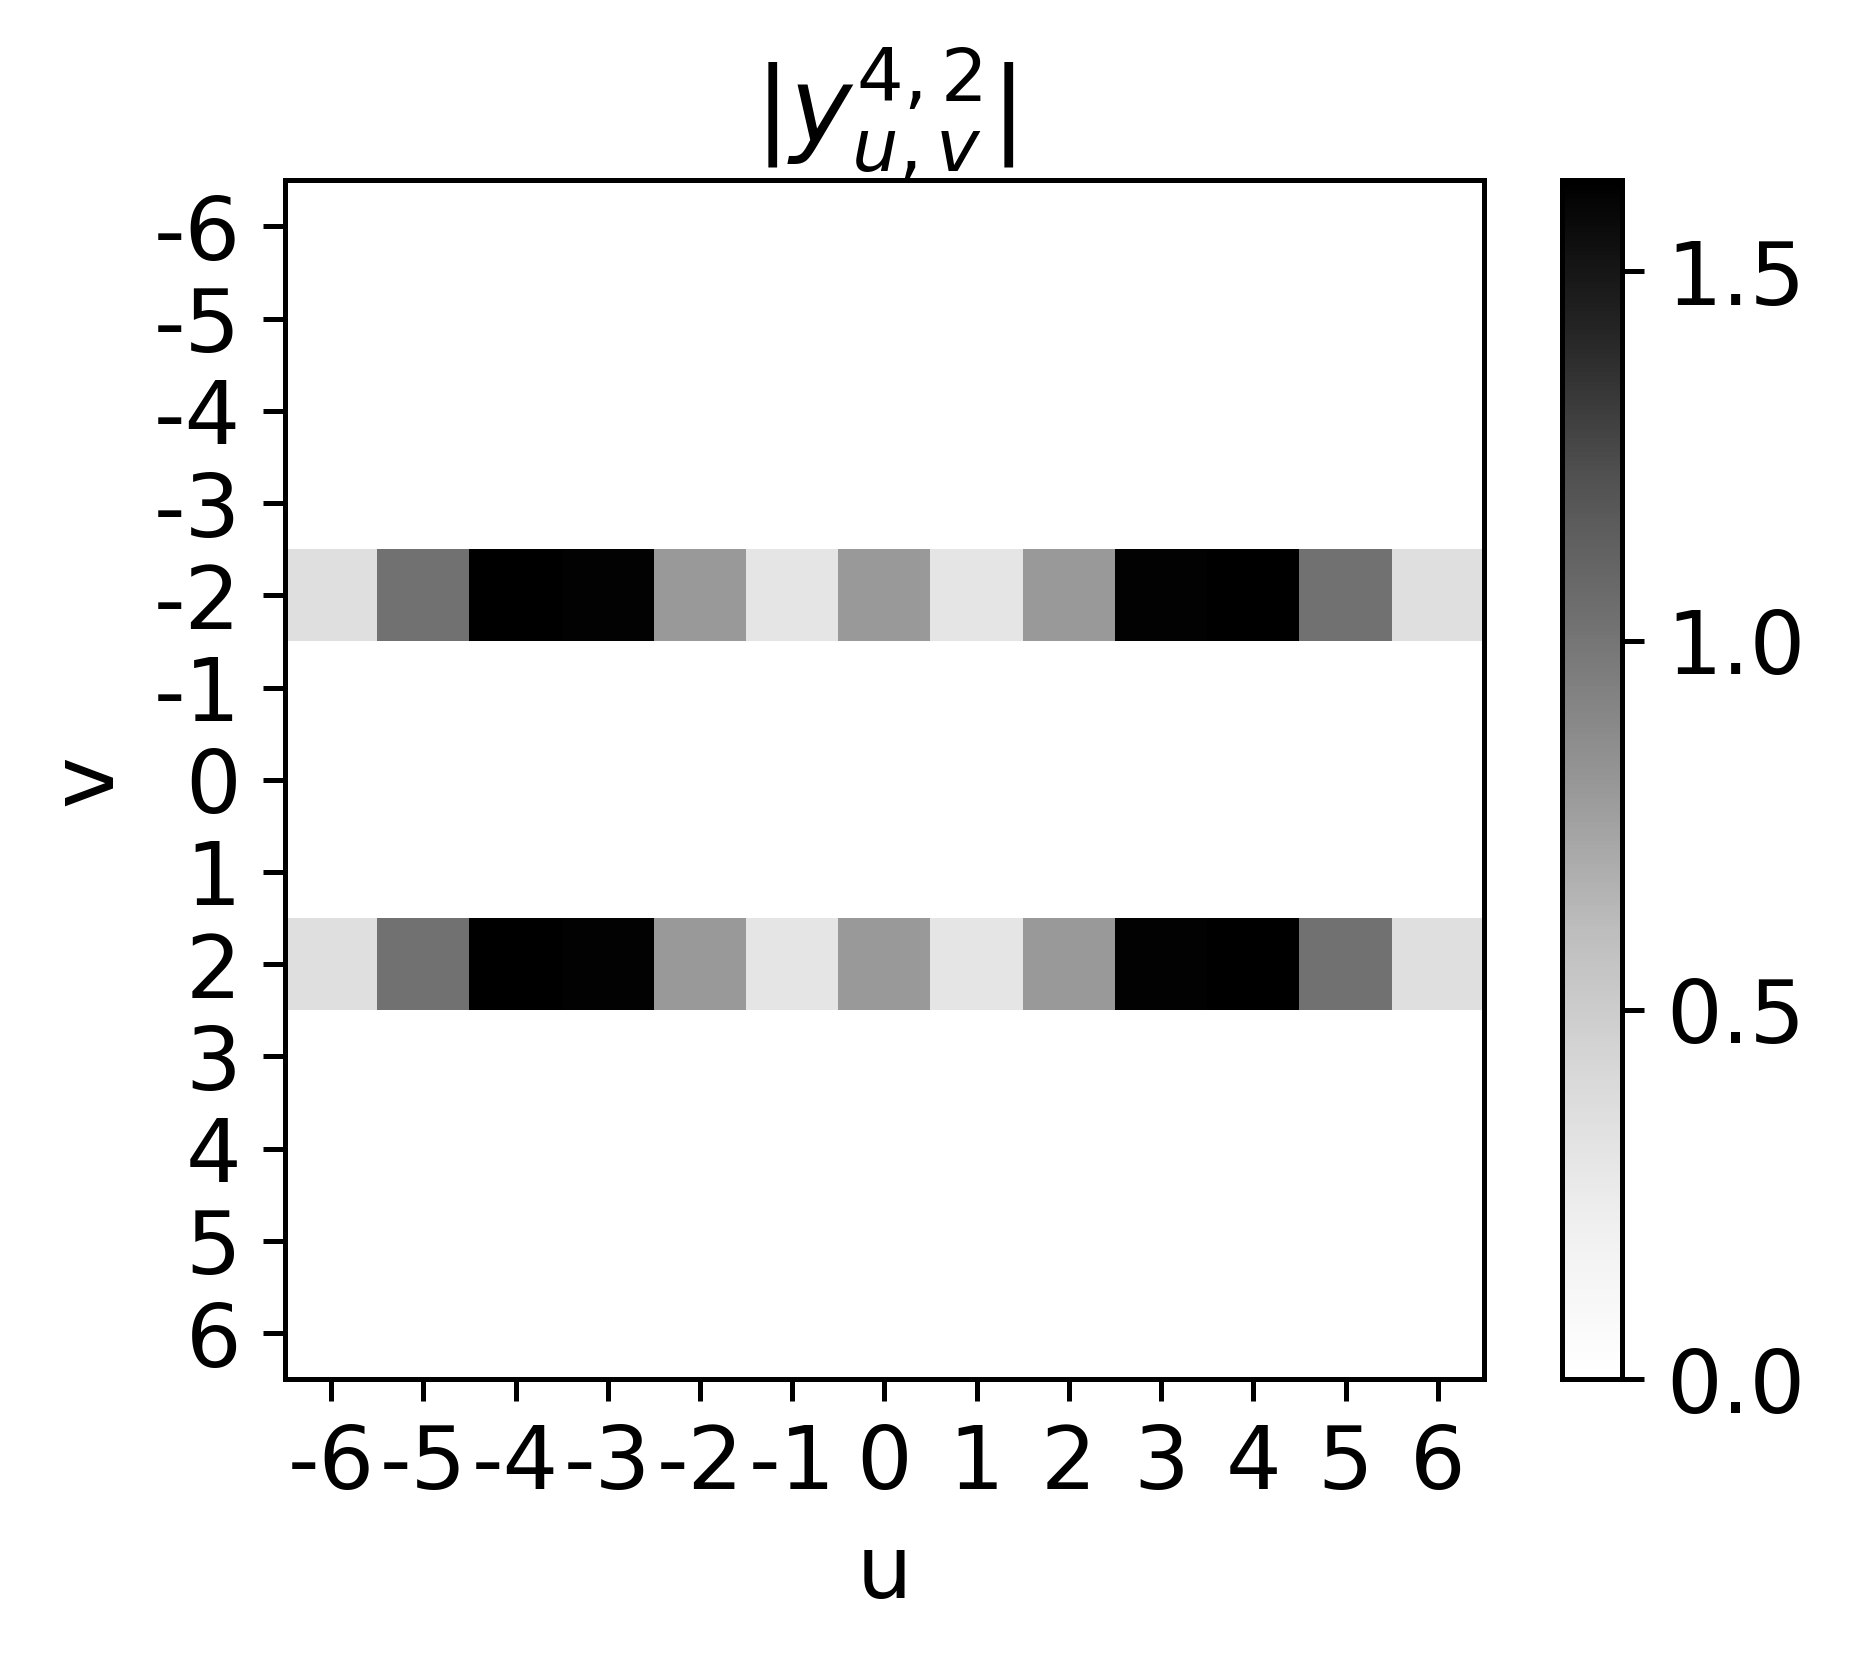

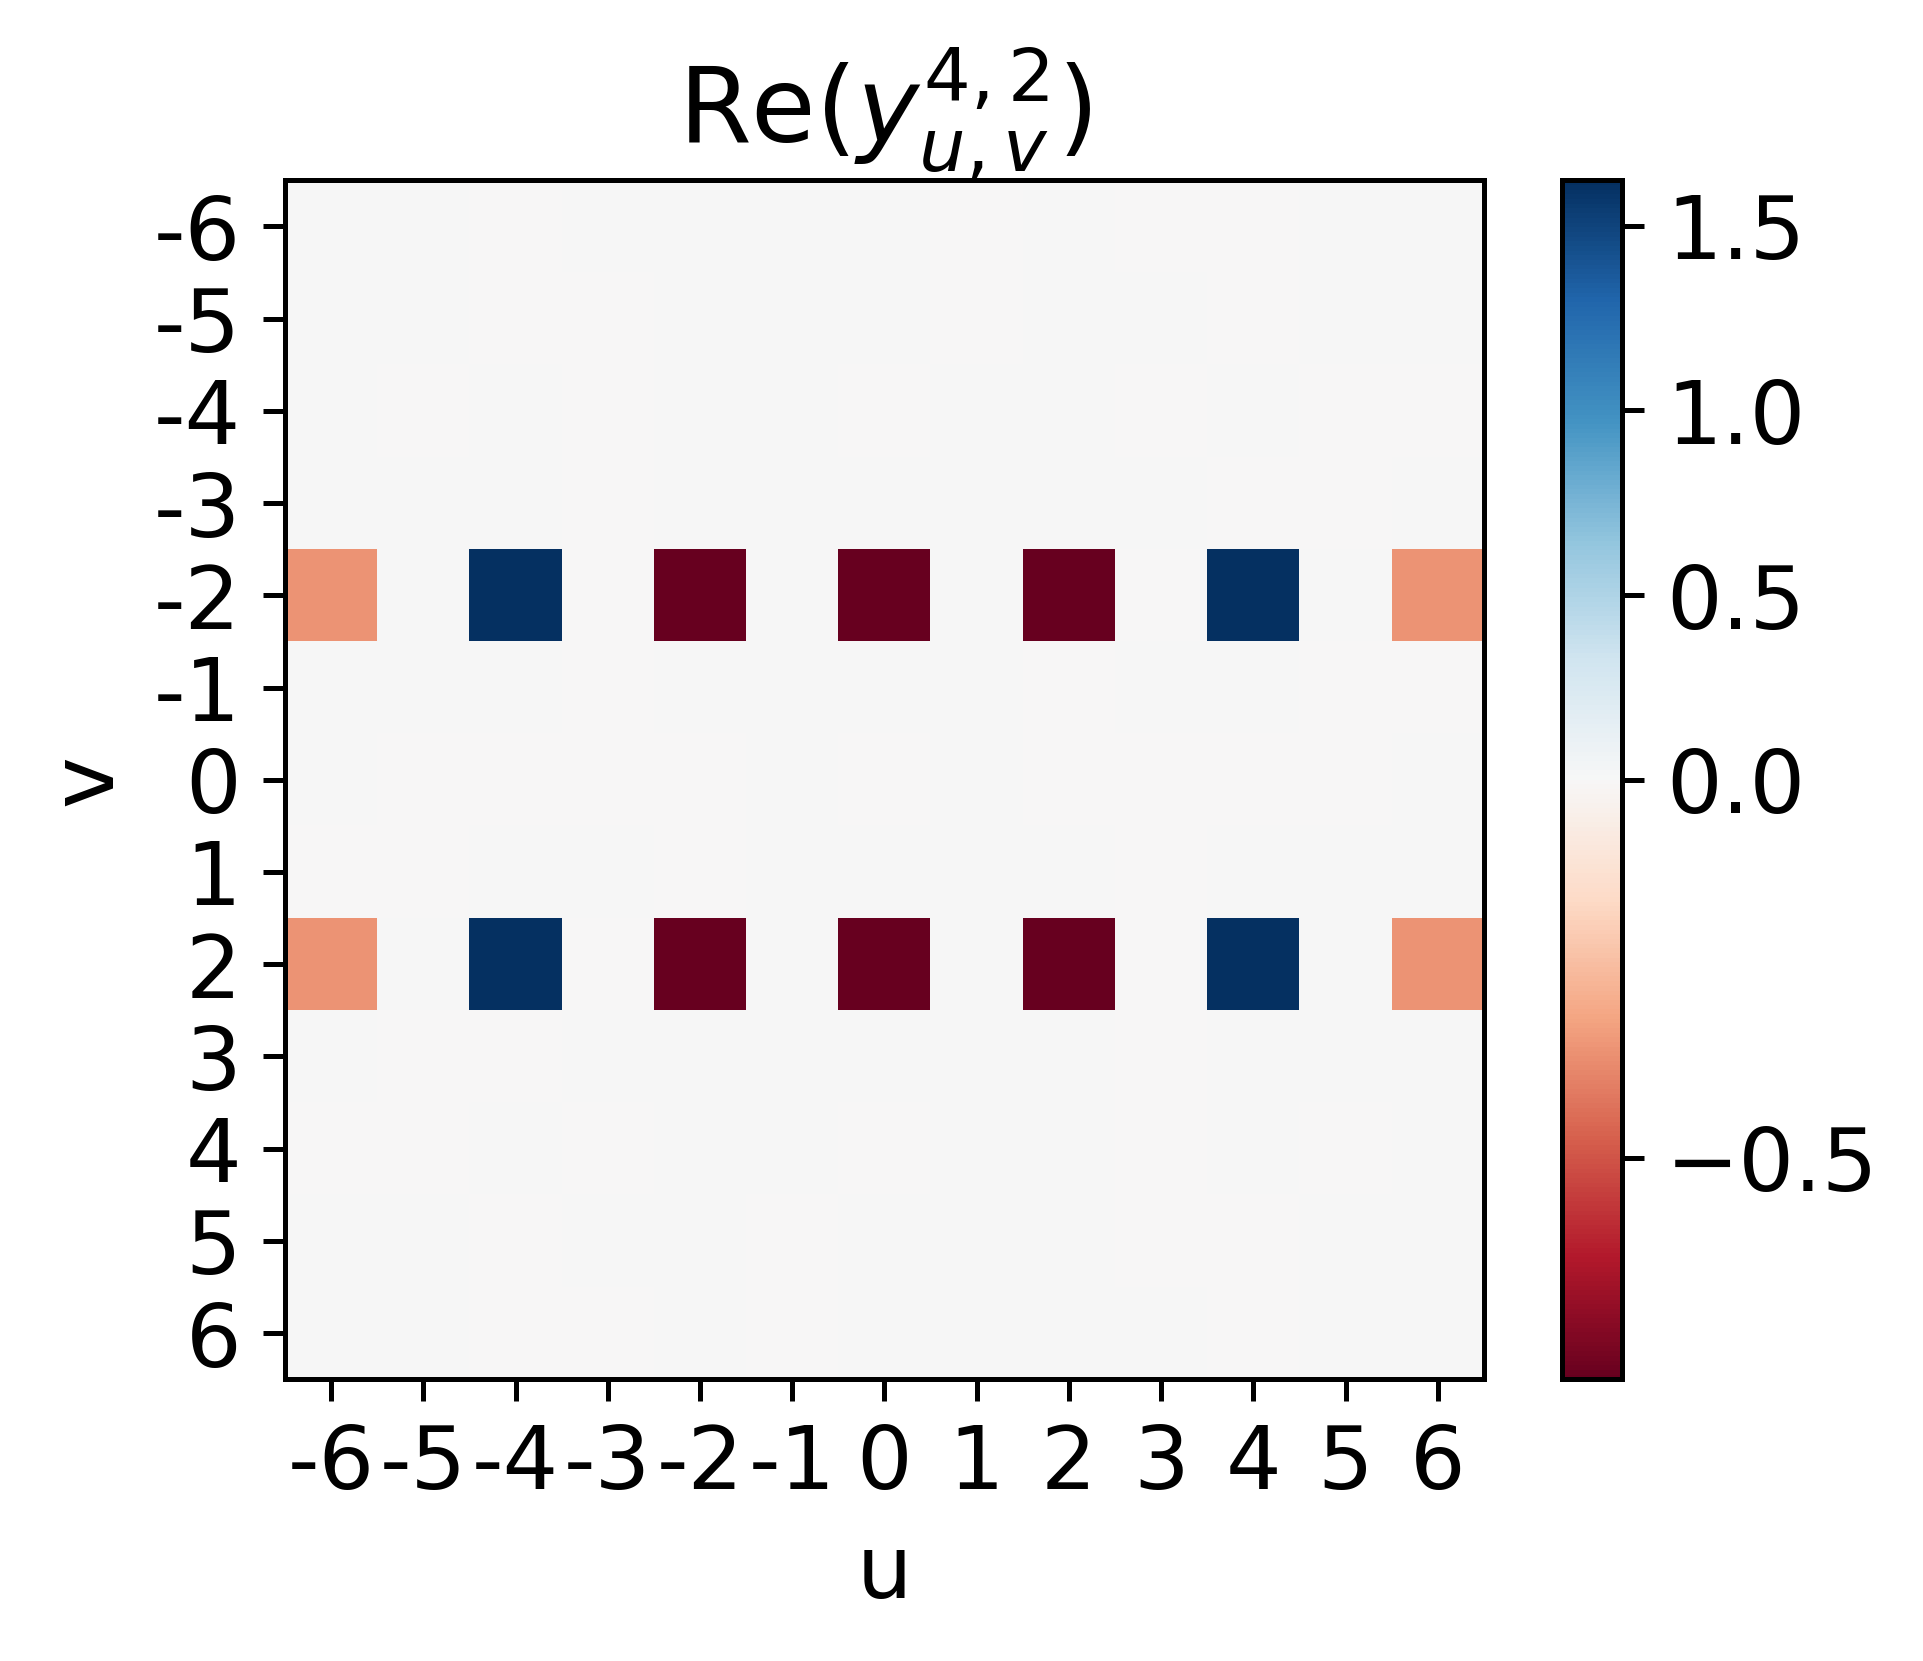

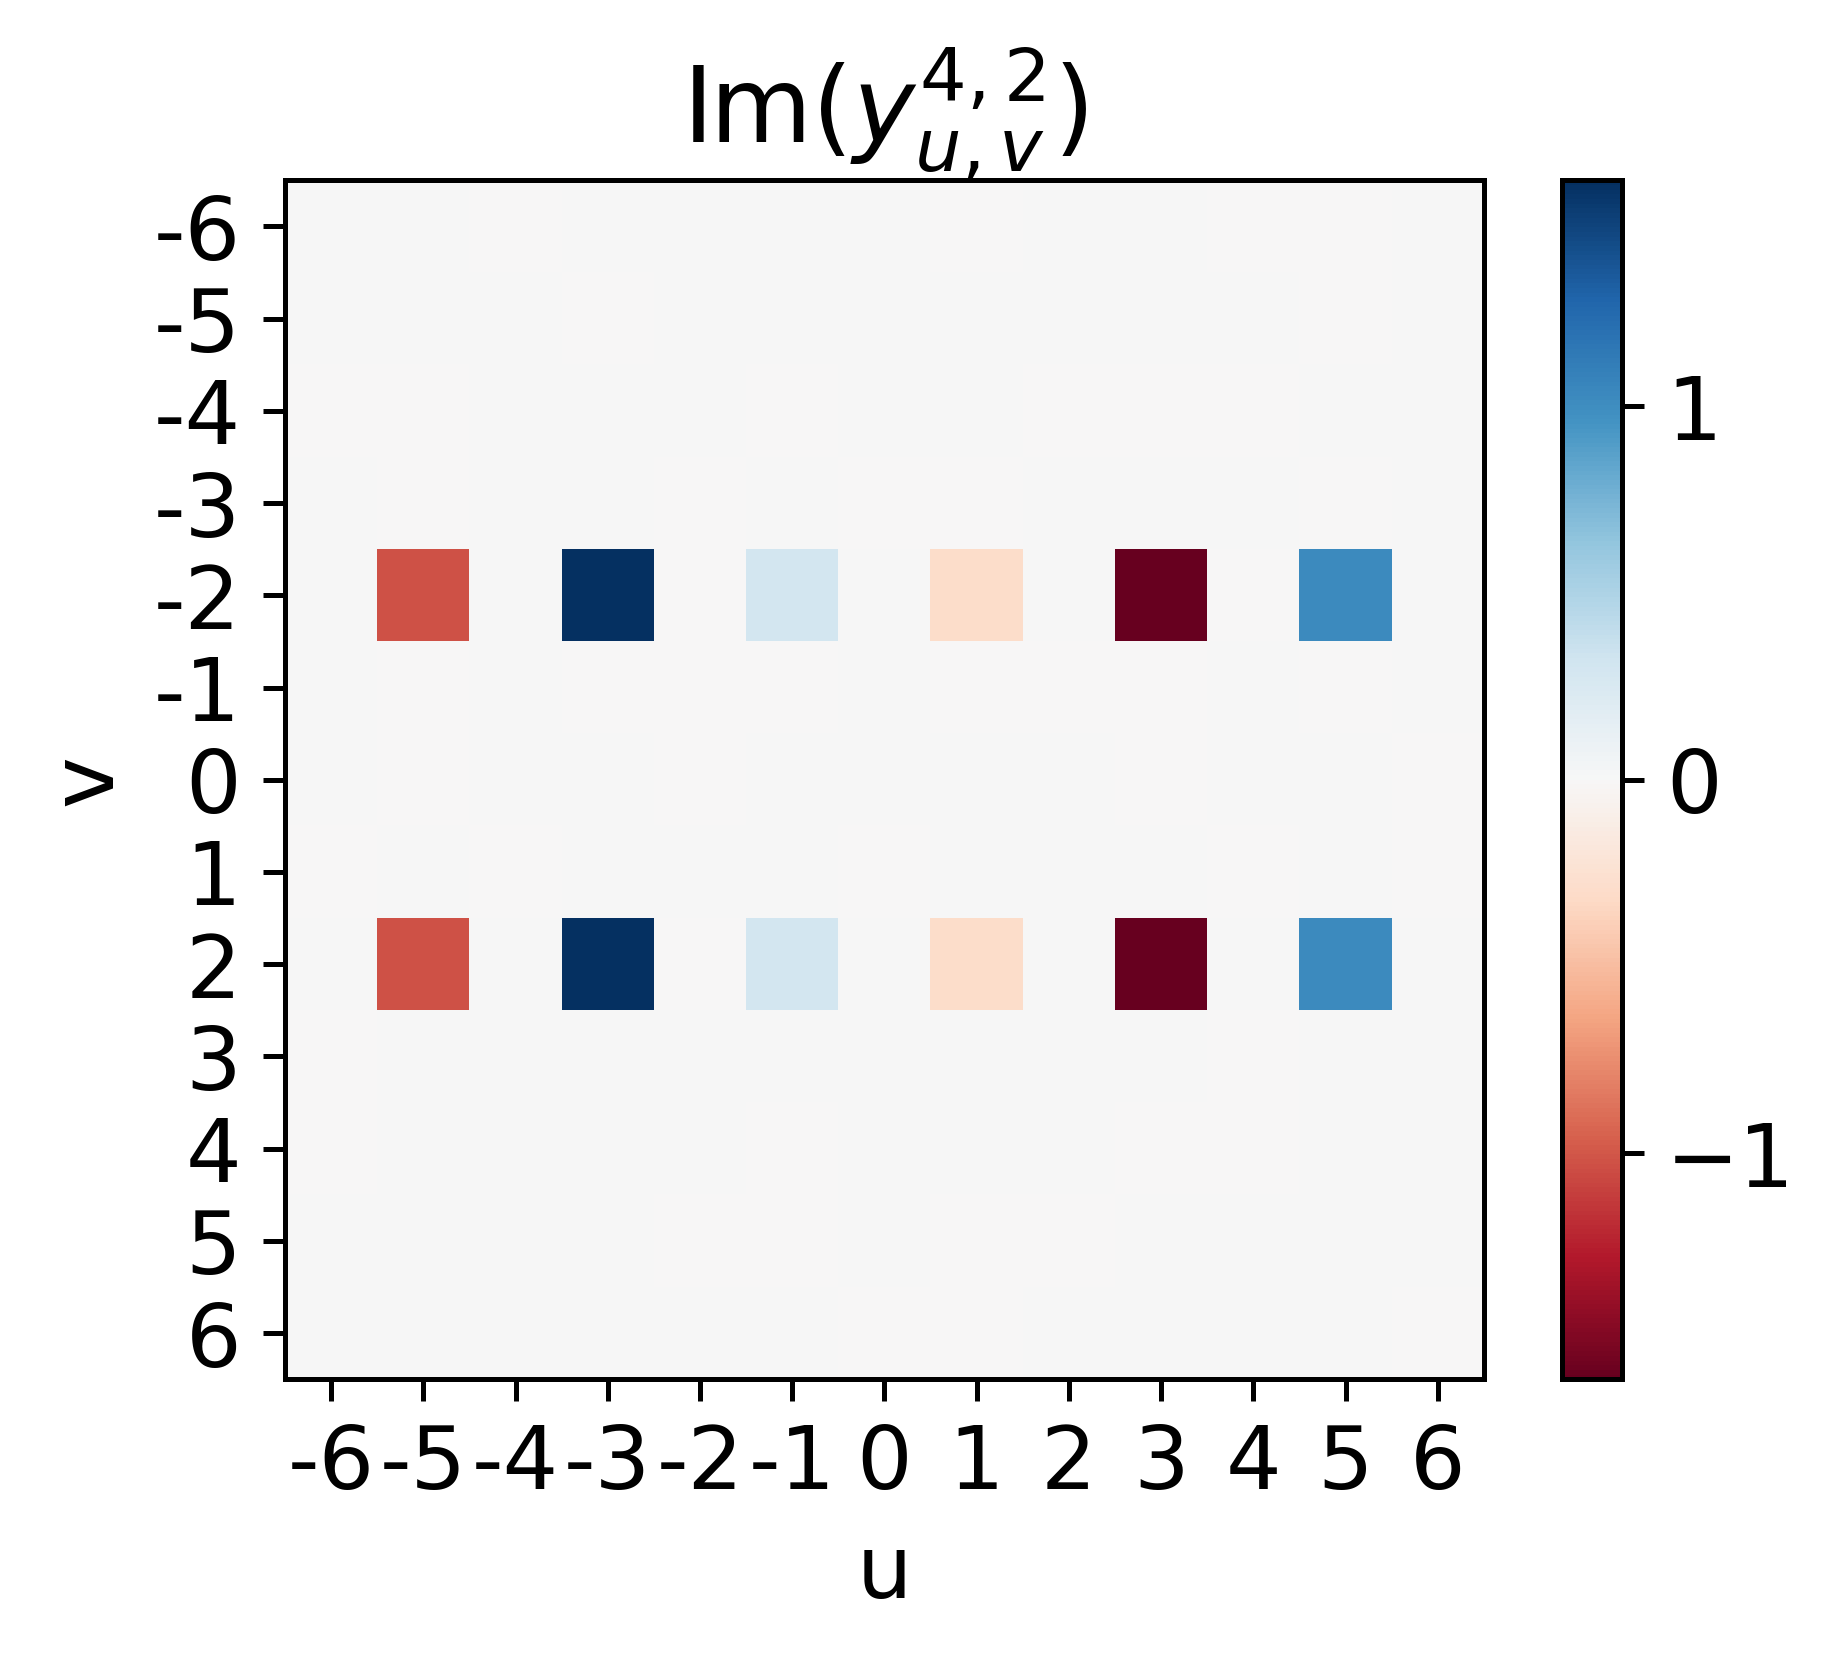

In [587]:
plt.imshow(jnp.abs(y_lm).T, cmap="Grays", vmin=0)
plt.title("$|y_{{u, v}}^{{%d,%d}}|$" % (l, m))
plt.xticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.yticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.xlabel("u")
plt.ylabel("v")
plt.colorbar()
plt.show()

norm = mcolors.TwoSlopeNorm(vmin=jnp.real(y_lm).min(), vcenter=0, vmax=jnp.real(y_lm).max())
plt.imshow(jnp.real(y_lm).T, cmap="RdBu", norm=norm)
plt.title("$\mathrm{{Re}}(y_{{u, v}}^{{%d,%d}})$" % (l, m))
plt.xticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.yticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.xlabel("u")
plt.ylabel("v")
plt.colorbar()
plt.show()


norm = mcolors.TwoSlopeNorm(vmin=jnp.imag(y_lm).min(), vcenter=0, vmax=jnp.imag(y_lm).max())
plt.imshow(jnp.imag(y_lm).T, cmap="RdBu", norm=norm)
plt.title("$\mathrm{{Im}}(y_{{u, v}}^{{%d,%d}})$" % (l, m))
plt.xticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.yticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.xlabel("u")
plt.ylabel("v")
plt.colorbar()
plt.show()

In [588]:
# Transform SH coefficients to 2D Fourier coefficients
x1_lm = e3nn.normal(e3nn.s2_irreps(lmax), key=jax.random.PRNGKey(1)).array
x1_uv = jnp.einsum("a, auv->uv", x1_lm, y_grid)
assert x1_uv.shape == (2 * lmax + 1, 2 * lmax + 1)

x2_lm = e3nn.normal(e3nn.s2_irreps(lmax), key=jax.random.PRNGKey(2)).array
x2_uv = jnp.einsum("a, auv->uv", x2_lm, y_grid)
assert x2_uv.shape == (2 * lmax + 1, 2 * lmax + 1)

In [589]:
z_grid = y_grid.transpose((0, 2, 1)).conj()
print(z_grid.shape)

(49, 13, 13)


In [590]:
# Check that we can convert back to SH coefficients
x1_lm_reconstructed = jnp.einsum("uv, auv->a", x1_uv, z_grid)
x1_lm_reconstructed[0], x1_lm[0]
# assert jnp.allclose(x1_lm, x1_lm_reconstructed)

(Array(-13.594726-3.2665037e-07j, dtype=complex64),
 Array(-0.76433897, dtype=float32))

In [591]:
# 2D FFT
x1_fft = jnp.fft.fft2(x1_uv)
x2_fft = jnp.fft.fft2(x2_uv)
assert x1_fft.shape == (2 * lmax + 1, 2 * lmax + 1)
assert x2_fft.shape == (2 * lmax + 1, 2 * lmax + 1)

# Product in Fourier space
x1_x2_fft = x1_fft * x2_fft
assert x1_x2_fft.shape == (2 * lmax + 1, 2 * lmax + 1)

# Inverse 2D FFT
x1_x2_uv = jnp.fft.ifft2(x1_x2_fft)
assert x1_x2_uv.shape == (2 * lmax + 1, 2 * lmax + 1)

# Convert back to spherical harmonics
x1_x2_lm = jnp.einsum("uv, auv->a", x1_x2_uv, jnp.conj(y_grid))
assert x1_x2_lm.shape == ((lmax + 1) ** 2,)

# Hmm, the result is not real, but it should be

In [592]:
x1_lm, x2_lm, x1_x2_lm

(Array([-0.76433897,  1.4304022 ,  0.29602233, -0.2620028 ,  0.7534696 ,
         0.38421908,  1.3584293 ,  1.9853761 , -0.5374943 , -1.2144603 ,
         1.1424834 ,  0.23388885, -0.977204  , -0.01199458,  0.6962024 ,
         1.3386534 ,  0.35359615,  1.3369001 ,  1.3061655 , -1.6693078 ,
        -0.12277574,  0.8758087 , -0.38047376, -0.8069952 ,  0.01533398,
         0.10265424,  0.12381285, -1.1133257 , -0.19076478,  1.4280903 ,
        -0.78696334,  1.7904425 ,  0.60417485, -0.29894122,  1.7950747 ,
        -1.4379933 ,  2.10746   , -0.05964555, -1.8987111 , -0.5051671 ,
        -0.56490016, -1.0505275 ,  0.39251304,  0.86643845,  1.1392976 ,
        -0.3791278 ,  1.6222832 ,  0.1660295 , -0.08054032], dtype=float32),
 Array([ 0.5731132 ,  0.94272035,  1.0079833 ,  0.00572866,  1.2520297 ,
        -0.5868313 ,  2.0336902 ,  0.5108802 ,  2.6709468 , -1.0808421 ,
         0.6009734 ,  0.57227564, -0.85571235, -2.0178416 , -0.16342053,
        -0.022926  ,  1.3772305 , -0.7710706 , 

In [593]:
x1_x2_lm

Array([  269.00574  -142.0556j  ,   260.28604  -334.22995j ,
          39.96815  +499.92892j ,  -157.27693  -479.93954j ,
        -745.5265   +333.6771j  ,   799.75684  +524.98456j ,
         468.9344   +291.14648j ,   540.5541   +162.46783j ,
         347.52133  +946.4293j  ,  -162.01437  -902.8748j  ,
         212.0781  +1979.2733j  ,  1113.9667   -380.89484j ,
        -312.1764   +404.05167j ,  -597.82935  -314.5689j  ,
        -571.88086 -1241.8121j  , -2246.8853  +2806.825j   ,
         810.4228  -1871.5654j  ,  -705.6231    +19.607443j,
         528.1218  -1109.9933j  ,   932.8343   -749.9643j  ,
       -1215.9724  -1020.8618j  , -1126.3905   +204.0613j  ,
        -582.3321  -2968.634j   , -1967.5028   -455.28494j ,
        1409.013   +1430.4332j  ,  -258.19104 +1753.8712j  ,
         624.05176 -1978.6348j  ,  -996.0851  +1007.1159j  ,
         313.066   -1141.296j   , -2411.3748   +584.2903j  ,
          38.353878-1263.0393j  ,  1332.8464   +380.34305j ,
        1368.7103  -1069

In [594]:
product = e3nn.to_s2grid(e3nn.IrrepsArray(e3nn.s2_irreps(lmax), x1_x2_lm), **s2grid_kwargs)
go.Figure([go.Surface(product.plotly_surface())])


TypeError: z.dtype=complex64 is not supported, see docstring for supported types.